Text(0.5, 1.0, 'Liczba błędnych klasyfikacji dla różnej liczby drzew')

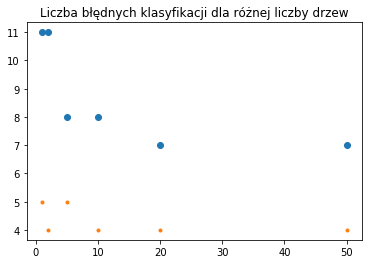

In [38]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

S1 = np.array([[4, 2], [2, 4]])
S2 = np.array([[4, 2], [2, 2]])
m1 = np.array([-1, 1])
m2 = np.array([2, 2])
n1 = 100
n2 = 100

def draw_data_gauss(S1, S2, m1, m2, n1, n2):
    X1 = np.random.multivariate_normal(m1, S1, n1)
    X2 = np.random.multivariate_normal(m2, S2, n2)
    tmp1 = np.full(n1, "1").T
    X1 = np.c_[X1, tmp1]
    X1 = pd.DataFrame(X1)
    X1.columns = ["x", "y", "Class"]
    X2 = pd.DataFrame(X2)
    tmp2 = np.full(n2, "2").T
    X2 = np.c_[X2, tmp2]
    X2 = pd.DataFrame(X2)
    X2.columns = ["x", "y", "Class"]
    data = np.r_[X1, X2]
    data = pd.DataFrame(data)
    data.columns = ["x", "y", "Class"]
    return data, X1, X2 # X1, X2 przydatne do losowania

def bagging_trees(dane_PU, dane_PT, M):
    drzewa_lista = []
    for m in range(M):
        dane_probka = dane_PU.sample(frac=1, replace=True)
        drzewo = tree.DecisionTreeClassifier()
        drzewo.fit(dane_probka.loc[:, 'x':'y'], dane_probka.loc[:, 'Class'])
        drzewa_lista.append(drzewo)
    class1_count = [0]*40
    class2_count = [0]*40
    class_assignment = [0]*40
    for i in range(40):
        for m in range(M):
            #print(dane_PT.loc[i:i, 'x':'y'])
            pred = drzewa_lista[m].predict(dane_PT.loc[i:i, 'x':'y'])
            #print(str(i)+" "+str(m)+" "+str(pred))
            if pred=='1':
                class1_count[i]+=1
            else:
                class2_count[i]+=1
        #print(str(i)+" "+str(class1_count[i])+" "+str(class2_count[i]))
        if np.count_nonzero(class1_count[i]>=class2_count[i]):
            class_assignment[i]='1'
        else:
            class_assignment[i]='2'
    class_array = np.asarray(class_assignment)
    return class_array

def bagging_LDA(dane_PU, dane_PT, M):
    LDA_lista = []
    for m in range(M):
        dane_probka = dane_PU.sample(frac=1, replace=True)
        lda = LinearDiscriminantAnalysis()
        lda.fit(dane_probka.loc[:, 'x':'y'], dane_probka.loc[:, 'Class'])
        LDA_lista.append(lda)
    class1_count = [0]*40
    class2_count = [0]*40
    class_assignment = [0]*40
    for i in range(40):
        for m in range(M):
            #print(dane_PT.loc[i:i, 'x':'y'])
            pred = LDA_lista[m].predict(dane_PT.loc[i:i, 'x':'y'])
            #print(str(i)+" "+str(m)+" "+str(pred))
            if pred=='1':
                class1_count[i]+=1
            else:
                class2_count[i]+=1
        #print(str(i)+" "+str(class1_count[i])+" "+str(class2_count[i]))
        if np.count_nonzero(class1_count[i]>=class2_count[i]):
            class_assignment[i]='1'
        else:
            class_assignment[i]='2'
    class_array = np.asarray(class_assignment)
    return class_array
    

dane, X1, X2 = draw_data_gauss(S1, S2, m1, m2, n1, n2)
dane_shuffled = dane.sample(frac=1)
dane_PU = dane_shuffled.iloc[0:159, :]
dane_PT = dane_shuffled.iloc[160:200, :].reset_index(drop=True)

drzewa_bledy_lista = []
LDA_bledy_lista = []
M_list = [1, 2, 5, 10, 20, 50]

for i in M_list:
    cross_table = pd.crosstab(dane_PT['Class'].values, bagging_trees(dane_PU, dane_PT, i))
    drzewa_bledy_lista.append(cross_table.to_numpy().sum() - np.diagonal(cross_table).sum()) # suma błędnych
    #print(cross_table.to_numpy().sum() - np.diagonal(cross_table).sum())  
    cross_table = pd.crosstab(dane_PT['Class'].values, bagging_LDA(dane_PU, dane_PT, i))
    #print(cross_table) 
    LDA_bledy_lista.append(cross_table.to_numpy().sum() - np.diagonal(cross_table).sum())
    
#print(LDA_bledy_lista)
fig, ax = plt.subplots(1, 1)
ax.plot(M_list, drzewa_bledy_lista, 'o', M_list, LDA_bledy_lista, '.')
ax.set_title('Liczba błędnych klasyfikacji dla różnej liczby drzew')
#ax.semilogx()